In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pylab as plt
import signs_utils
import alexnet_utils
from alexnet import AlexNet
import cv2
import sys
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = signs_utils.load_dataset()

In [5]:
print('train_set_x_orig: ', train_set_x_orig.shape)
print('train_set_y_orig: ', train_set_y_orig.shape)
print('test_set_x_orig: ', test_set_x_orig.shape)
print('test_set_y_orig: ', test_set_y_orig.shape)
print('class:{0}'.format(classes))

train_set_x_orig:  (1080, 64, 64, 3)
train_set_y_orig:  (1, 1080)
test_set_x_orig:  (120, 64, 64, 3)
test_set_y_orig:  (1, 120)
class:[0 1 2 3 4 5]


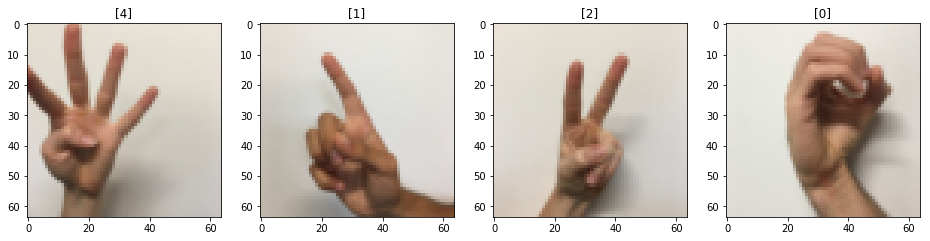

In [6]:
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(test_set_x_orig[i+50])
    plt.title(test_set_y_orig[:, i+50])

In [7]:
IMAGE_SAHPE = (68, 68)

In [8]:
def resize_images(images):
    images_list = [cv2.resize(i, IMAGE_SAHPE) for i in images]
    resize_images = np.array(images_list)
    return resize_images

In [9]:
train_x_set = resize_images(train_set_x_orig) - alexnet_utils.rgb_shift
train_y_set = signs_utils.convert_to_one_hot(train_set_y_orig, 6).T
test_x_set = resize_images(test_set_x_orig) - alexnet_utils.rgb_shift
test_y_set = signs_utils.convert_to_one_hot(test_set_y_orig, 6).T

In [10]:
print('train_x_set: ', train_x_set.shape)
print('train_y_set: ', train_y_set.shape)
print('test_x_set: ', test_x_set.shape)
print('test_y_set: ', test_y_set.shape)

train_x_set:  (1080, 68, 68, 3)
train_y_set:  (1080, 6)
test_x_set:  (120, 68, 68, 3)
test_y_set:  (120, 6)


In [23]:
def compute_cost(Z_last, Y):
    with tf.name_scope('Cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z_last, labels=Y))
        
    return cost

In [24]:
def compute_accuracy(Z_last, Y):
    with tf.name_scope('Accuracy'):
        right_predictions = tf.equal(tf.argmax(Z_last, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(right_predictions, tf.float32))
    
    return accuracy

In [73]:
VARS_SAVE_PATH = './save'

In [74]:
def save_train_vars(sess, path):
    if not os.path.exists(VARS_SAVE_PATH):
        os.mkdir(VARS_SAVE_PATH)
        
    saver = tf.train.Saver(tf.trainable_variables())
    saver.save(sess, os.path.join(VARS_SAVE_PATH, 'alexnet_train_vars'))

In [75]:
def restore_train_vars(sess, path):
    if not os.path.exists(VARS_SAVE_PATH):
        os.mkdir(VARS_SAVE_PATH)
    else:
        save_path = os.path.join(VARS_SAVE_PATH, 'checkpoint')
        if os.path.exists(save_path):
            saver = tf.train.Saver(tf.trainable_variables())
            saver.restore(sess, os.path.join(VARS_SAVE_PATH, 'alexnet_train_vars'))

In [76]:
def fineturn_alexnet(X_train, Y_train, X_dev, Y_dev,epoch=1, batch_size=64,
                     learning_rate=0.01, keep_prob=1, resume=False):
    tf.reset_default_graph()
    
    train_mini_batches = signs_utils.random_mini_batches(X_train, Y_train, mini_batch_size=batch_size)
    test_mini_batches = signs_utils.random_mini_batches(X_dev, Y_dev, mini_batch_size=batch_size)
    
    alexnet = AlexNet(image_shape=(IMAGE_SAHPE[0], IMAGE_SAHPE[1], 3), 
                      classes_num=6, freeze_layer_indexes=(1, 2, 3, 4, 5))
    
    alex_interface = alexnet.interface()
    X_p = alex_interface['input_placeholder']
    keep_prob_p = alex_interface['keep_prob_placeholder']
    output_op = alex_interface['output_Z']

    Y_p = tf.placeholder(shape=(None, 6), dtype=tf.float32)
        
    cost_op = compute_cost(output_op, Y_p)
    accuracy_op = compute_accuracy(output_op, Y_p)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)
        
    init_op = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init_op)
    
    alexnet.load_imagenet_weights(sess, skip_layer_indexes=(8, 7, 6))
    
    if resume:
        restore_train_vars(sess, VARS_SAVE_PATH)
    
    costs = []
    step = 0
    
    for i in range(epoch):  
        for X_batch, Y_batch in train_mini_batches:
            sess.run(optimizer, 
                     feed_dict={X_p: X_batch, Y_p: Y_batch, keep_prob_p: keep_prob})
            step += 1
        
            if step % 2 == 0:
                cost = cost_op.eval(session=sess, 
                                    feed_dict={X_p: X_batch, Y_p: Y_batch, keep_prob_p: 1})
                accuracy = accuracy_op.eval(session=sess, 
                                            feed_dict={X_p: X_batch, Y_p: Y_batch, keep_prob_p: 1})
                
                
                costs.append(cost)
                
                out_str = 'epoch: {epoch} - step: {step} - cost: {cost} - accuracy: {accuracy:.2f}%        \r'.format(
                    epoch = i,
                    step = step,
                    cost = cost,
                    accuracy = accuracy * 100
                )              
                sys.stdout.write(out_str)
                sys.stdout.flush()
        print('')
                
    train_accuracy = 0
    for X_train, Y_train in train_mini_batches:
        accuracy = accuracy_op.eval(session=sess, 
                                    feed_dict={X_p: X_train, Y_p: Y_train, keep_prob_p: 1})
        train_accuracy += accuracy * (X_train.shape[0] / train_x_set.shape[0])
        
    print('train_dataset accuracy:',str(train_accuracy * 100), '%')
    
    test_accuracy = 0
    for X_test, Y_test in test_mini_batches:
        accuracy = accuracy_op.eval(session=sess, 
                                    feed_dict={X_p: X_test, Y_p: Y_test, keep_prob_p: 1})
        test_accuracy += accuracy * (X_test.shape[0] / test_x_set.shape[0])
        
    print('test_dataset accuracy:',str(test_accuracy * 100), '%')
                
            
    plt.plot(costs)
    plt.title('learing_rate:' + str(learning_rate) + '-' +  'step:' + str(step))
    
    save_train_vars(sess, VARS_SAVE_PATH)
    
    sess.close()

Found and verified ./alexnet_weights.npy
INFO:tensorflow:Restoring parameters from ./save/alexnet_train_vars
epoch: 0 - step: 16 - cost: 2.729712286964059e-05 - accuracy: 100.00%         
epoch: 1 - step: 34 - cost: 0.0001480922510381788 - accuracy: 100.00%         
train_dataset accuracy: 100.0 %
test_dataset accuracy: 96.6666678588 %


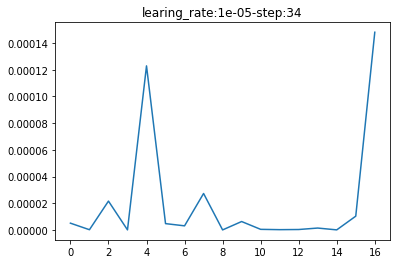

In [77]:
fineturn_alexnet(train_x_set, train_y_set, test_x_set, test_y_set, epoch=2, keep_prob=0.5,
                 learning_rate=0.00001, resume=True)